<a href="https://colab.research.google.com/github/Adricarpin/TensorFlow-notebooks/blob/master/NLP/Sentiment_analysis_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In this notebook I will use the IMDB reviews for sentiment analysis

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="IMDBReviews", 
                                             split=["train", "test"], # set the splits of data we will get (see documentation)
                                             shuffle_files=True, # shuffle files on download
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9J92LB/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9J92LB/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9J92LB/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


# What is the data about?

In [ ]:
ds_info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names

['neg', 'pos']

In [ ]:
for x , y in train_data.take(3):
  print(x)
  print(y)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

# tf.data.Dataset to Numpy

In [ ]:
import numpy as np


training_sentences = []
training_labels = []

for x,y in train_data:
  training_sentences.append(x.numpy().decode('utf8'))
  training_labels.append(y.numpy())

train_X = np.array(training_sentences)
train_y = np.array(training_labels)

In [ ]:
# text data
import numpy as np

test_sentences = []
test_labels = []

for x,y in test_data:
  test_sentences.append(x.numpy().decode('utf8')) 
  test_labels.append(y.numpy())

test_X = np.array(test_sentences)
test_y = np.array(test_labels)

# Tokenization

In [ ]:
# See labels labels distribution
sum(train_y) 

12500

## looking for a token vector size

In [ ]:
sent_lens = [len(i.split()) for i in train_X]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

233.7872

(array([7.2210e+03, 1.0446e+04, 3.6260e+03, 1.7010e+03, 9.0400e+02,
        4.9000e+02, 2.9000e+02, 2.3400e+02, 6.8000e+01, 5.0000e+00,
        4.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10.,  133.,  256.,  379.,  502.,  625.,  748.,  871.,  994.,
        1117., 1240., 1363., 1486., 1609., 1732., 1855., 1978., 2101.,
        2224., 2347., 2470.]),
 <a list of 20 Patch objects>)

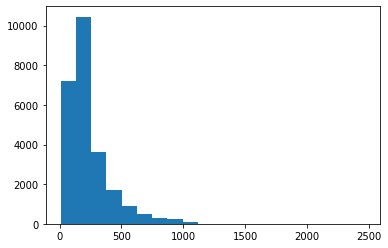

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

598

## vocabulary size

In [ ]:
len(set(' '.join(train_X).split(" ")))

281158

## Tokenizer

In [ ]:
from tensorflow.keras.layers import TextVectorization


vocab_dim = 5000
token_vector_len = 50

text_vectorizer = TextVectorization(max_tokens = vocab_dim, # how many words in the vocabulary (all of the different words in your text)
                                    output_sequence_length=token_vector_len) # how long should the output sequence of tokens be?


In [ ]:
text_vectorizer.adapt(train_X)


# Subset

In [ ]:
make_split_train = int(0.1*len(train_X))
train_X_mini = train_X[:make_split_train]
train_y_mini = train_y[:make_split_train]

In [ ]:
make_split_test = int(0.1*len(test_X))
test_X_mini = test_X[:make_split_test]
test_y_mini = test_y[:make_split_test]

In [ ]:
len(test_X_mini)

2500

# Model 1 (tfidf)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

model_1.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
baseline_score = model_1.score(test_X, test_y)
baseline_score

0.82956

# Model 2 (LSTM)

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=vocab_dim, # set input shape
                             output_dim=32, # set size of embedding vector
                             input_length=token_vector_len) 


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_2 = Model(input, output)

In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

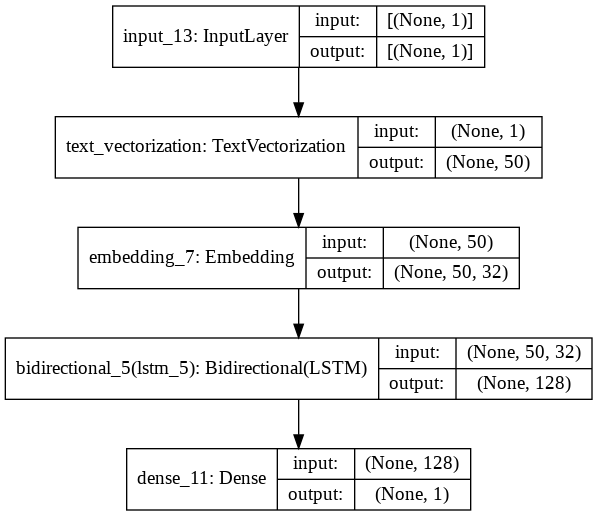

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes=True)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)


In [ ]:
history_2 = model_2.fit(train_X, train_y, epochs=4,
               validation_data=(test_X,test_y),
               verbose=1, callbacks=[reduce_lr])

Epoch 1/4
782/782 [==============================] - 37s 42ms/step - loss: 0.5301 - accuracy: 0.7243 - val_loss: 0.4808 - val_accuracy: 0.7646
Epoch 2/4
782/782 [==============================] - 32s 41ms/step - loss: 0.4156 - accuracy: 0.8066 - val_loss: 0.4794 - val_accuracy: 0.7625
Epoch 3/4
782/782 [==============================] - 32s 41ms/step - loss: 0.3724 - accuracy: 0.8310 - val_loss: 0.5018 - val_accuracy: 0.7530
Epoch 4/4
782/782 [==============================] - 32s 41ms/step - loss: 0.3238 - accuracy: 0.8584 - val_loss: 0.5253 - val_accuracy: 0.7487


# Model 3 (Conv)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf


In [ ]:
embedding = layers.Embedding(input_dim=vocab_dim, # set input shape
                             output_dim=32, # set size of embedding vector
                             input_length=token_vector_len) 


input = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = layers.Conv1D(filters = 10,
                  kernel_size = 4,
                  activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_3 = Model(input, output)

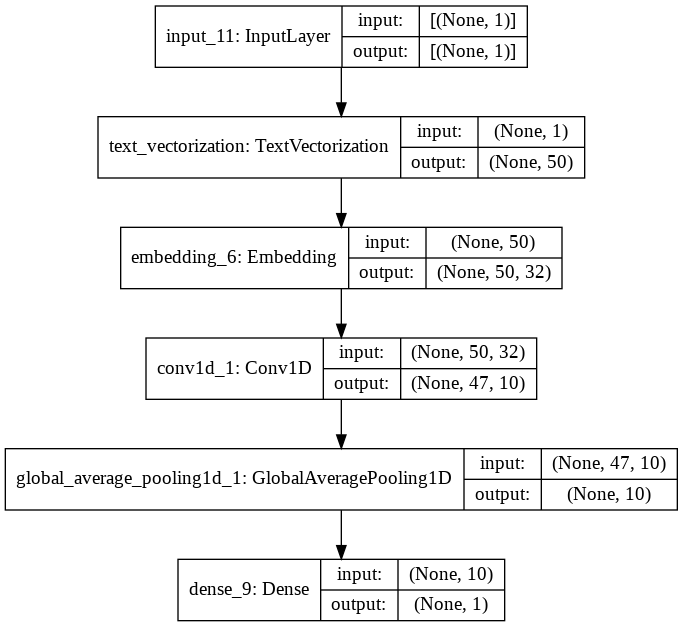

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True)

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
history_3 = model_3.fit(train_X, 
                      train_y,
                      epochs = 5,
                      validation_data= (test_X, test_y))

Epoch 1/5
782/782 [==============================] - 12s 15ms/step - loss: 0.5549 - accuracy: 0.7018 - val_loss: 0.4850 - val_accuracy: 0.7621
Epoch 2/5
782/782 [==============================] - 11s 14ms/step - loss: 0.4243 - accuracy: 0.8053 - val_loss: 0.4905 - val_accuracy: 0.7604
Epoch 3/5
782/782 [==============================] - 11s 14ms/step - loss: 0.3918 - accuracy: 0.8234 - val_loss: 0.5014 - val_accuracy: 0.7592
Epoch 4/5
782/782 [==============================] - 11s 14ms/step - loss: 0.3711 - accuracy: 0.8343 - val_loss: 0.5123 - val_accuracy: 0.7570
Epoch 5/5
782/782 [==============================] - 11s 14ms/step - loss: 0.3562 - accuracy: 0.8408 - val_loss: 0.5287 - val_accuracy: 0.7522


# Model 4 (BERT 10% data)

In [ ]:
! pip install -q -U tensorflow-text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [ ]:
import tensorflow_text
import tensorflow_hub as hub

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", trainable=False)

inputs = layers.Input(shape=(), dtype="string")
encoder_inputs = preprocessor(inputs)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
net = layers.Dropout(0.1)(pooled_output)
net = layers.Dense(1, activation='sigmoid')(net)
model_4 = tf.keras.Model(inputs, net)

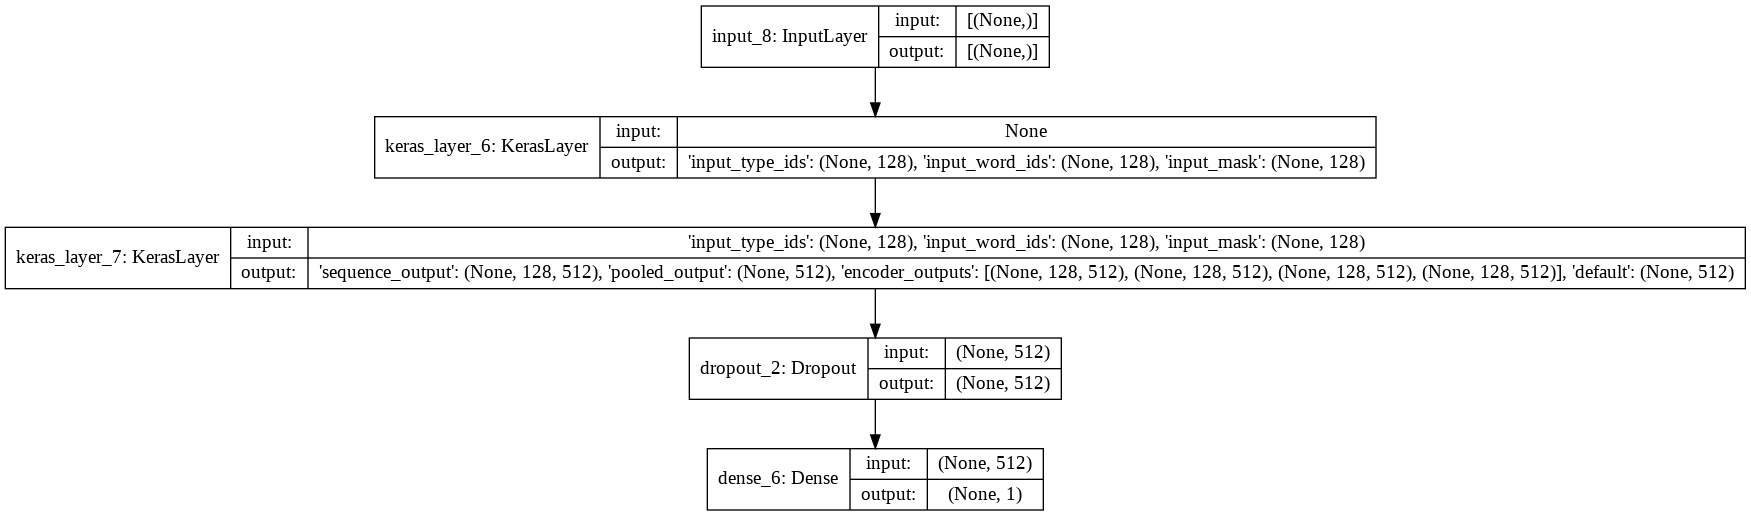

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
history_4 = model_4.fit(train_X_mini, 
                      train_y_mini,
                      epochs = 5,
                      validation_data= (test_X_mini, test_y_mini))

Epoch 1/5
79/79 [==============================] - 37s 425ms/step - loss: 0.7102 - accuracy: 0.5424 - val_loss: 0.6556 - val_accuracy: 0.6200
Epoch 2/5
79/79 [==============================] - 32s 409ms/step - loss: 0.6426 - accuracy: 0.6336 - val_loss: 0.6104 - val_accuracy: 0.6780
Epoch 3/5
79/79 [==============================] - 31s 398ms/step - loss: 0.6038 - accuracy: 0.6736 - val_loss: 0.5815 - val_accuracy: 0.7060
Epoch 4/5
79/79 [==============================] - 31s 394ms/step - loss: 0.5883 - accuracy: 0.6900 - val_loss: 0.5689 - val_accuracy: 0.7124
Epoch 5/5
79/79 [==============================] - 31s 394ms/step - loss: 0.5699 - accuracy: 0.7056 - val_loss: 0.5532 - val_accuracy: 0.7264


# Model 4 (BERT 100% data)

In [ ]:
! pip install -q -U tensorflow-text

In [ ]:
import tensorflow_text
import tensorflow_hub as hub

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", trainable=False)

inputs = layers.Input(shape=(), dtype="string")
encoder_inputs = preprocessor(inputs)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
net = layers.Dropout(0.1)(pooled_output)
net = layers.Dense(1, activation='sigmoid')(net)
model_5 = tf.keras.Model(inputs, net)

In [ ]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
history_5 = model_5.fit(train_X, 
                      train_y,
                      epochs = 5,
                      validation_data= (test_X, test_y))

Epoch 1/5
782/782 [==============================] - 331s 419ms/step - loss: 0.5902 - accuracy: 0.6848 - val_loss: 0.5366 - val_accuracy: 0.7361
Epoch 2/5
782/782 [==============================] - 321s 411ms/step - loss: 0.5393 - accuracy: 0.7297 - val_loss: 0.5378 - val_accuracy: 0.7330
Epoch 3/5
782/782 [==============================] - 317s 405ms/step - loss: 0.5315 - accuracy: 0.7320 - val_loss: 0.5283 - val_accuracy: 0.7330
Epoch 4/5
782/782 [==============================] - 312s 399ms/step - loss: 0.5282 - accuracy: 0.7352 - val_loss: 0.5325 - val_accuracy: 0.7320
Epoch 5/5
782/782 [==============================] - 317s 405ms/step - loss: 0.5256 - accuracy: 0.7378 - val_loss: 0.5368 - val_accuracy: 0.7261
